In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from time import localtime, strftime

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
# Number of samples in each class

TEST_SAMPLE_NUMBER = 51731
TRAIN_SAMPLE_NUMBER = 257187

# array1: [sX1; sY1; sX2; sY2; ...]
# array2: [eX1; eY1; eX2; eY2; ...]
# output: [dist((sX1, sY1), (eX1, eY1)), dist((sX1, sY1), (eX1, eY1)),
#          dist((sX2, sY2), (eX2, eY2)), dist((sX2, sY2), (eX2, eY2)), ...]

def distance_for_each_point(array1, array2):
    array_length = len(array1)
    len2 = len(array2)
    assert (array_length == len2), "Arrays' sizes have to be equal (array1: {}, array2: {})".format(array_length, len2)
    
    if array1.ndim == 1:
        distance = np.linalg.norm((array1 - array2).reshape((int(array_length / 2), 2)), axis=1)
        result = np.array([[d, d] for d in distance]).flatten()
    else:
        result = np.array([distance_for_each_point(array1[i], array2[i]) for i in range(array_length)])
    
    return result

# metrics between real results (in tests) and predicted
def distance(test_results, predicted_results):
    return distance_for_each_point(np.array(test_results), predicted_results).sum() / TEST_SAMPLE_NUMBER / 2

# data may be present as [n_features * n_samples] or [n_samples * n_features] 
# usually algorithms require second variant but I prefer first
def to_model(df):
    return np.array(df).T.reshape((int(df.shape[1] / 2), 10))
def from_model(npa):
    return npa.reshape((len(npa) * 2, 5)).T

In [3]:
# you need to pass as arguments function to execute, test_results to compare with predicted by function,
# parameter_name to know results by which parameter you want to compare and list_of_values for this parameter
# also you need to pass other argument which function will use 
# it's always some test_data and usually train_data and train_results

def compare_results(function, test_results, parameter_name, list_of_values, **other_parameters):
    result = [] # we will keep results for each configuration here

    for i, value in enumerate(list_of_values):
        print("{cur}/{num}: {t}".format(cur=i+1, num=len(list_of_values), t=strftime("%Y-%m-%d %H:%M:%S", localtime())))
        other_parameters[parameter_name] = value        
        predicted_results = function(**other_parameters)
        np.save("src/Logs/{date}_predicted_coordinates_{function_name}_{parameter_name}_".format(
                date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name)
                + str(value), predicted_results)
        result.append(distance(test_results, predicted_results))
        
    print("done! {time}".format(time=strftime("%Y-%m-%d %H:%M:%S", localtime())))
    print("Results: {}".format(result))
        
    ind = list_of_values
    number = len(ind)
    width = 2 / number
    result_bar = plt.bar(range(number), result, width, color='g')

    plt.ylabel('Average difference')
    plt.xlabel(parameter_name)
    plt.title("Difference between real points and predicted by {parameter_name} in {function_name}".format(
        function_name=function.__name__, parameter_name=parameter_name))
    plt.xticks(np.array(range(number)) + width/2, ind)
    plt.savefig("src/Plots/{date}_{function_name}_difference_by_{parameter_name}.png".format(
        date=strftime("%Y%m%d", localtime()), function_name=function.__name__, parameter_name=parameter_name))    

In [4]:
ZERO_PADDING = 6

def get_filename(index):
    return "src/Csv/{}.txt".format(str(index).zfill(ZERO_PADDING))

def get_framename(index):
    return "src/Frame/{}.jpg".format(str(index).zfill(ZERO_PADDING))

NUMBER_OF_PEDESTRIANS = 12273

def download_pedestrian(index):
    assert(0 <= index < NUMBER_OF_PEDESTRIANS), "pedestrian number should be between 0 and {max}; given number: {id}".format(
        max=NUMBER_OF_PEDESTRIANS-1, id=index)
    filename = get_filename(index)
    data = pd.read_csv(filename, index_col=0)
    return data

In [5]:
def make_view(data, length, only_odd_rows=True):
    data = np.array(data).flatten()
    len1 = len(data)
    len2 = length
    return np.lib.stride_tricks.as_strided(data, shape=(len1 - len2 + 1, len2),
                                                    strides=(data.dtype.itemsize,) * 2)[::2 if only_odd_rows else 1, :]

In [6]:
def draw_lines(frame_number, paths, colors, image_name, draw_line=True):
    im = Image.open(get_framename(frame_number))
    draw = ImageDraw.Draw(im)
    for path, color in zip(paths, colors):
        if draw_line:
            path_view = make_view(path, 4)
            for line in path_view:
                draw.line(tuple(line), width=4, fill=color)
        else:
            for point in path:
                draw.ellipse(tuple(np.append(point, point+10)), fill=color)

    im.save("src/Images/{name}.jpg".format(name=image_name))

In [7]:
def find_by_path(path, search_in_test=True):
    
    indices = np.arange(NUMBER_OF_PEDESTRIANS)
    if search_in_test:
        pedestrian_separation = pd.read_csv('src/pedestrian_labels_and_test_and_train_separation.csv', index_col=0)
        indices = np.where(np.array(pedestrian_separation['category']) == 'test')[0]
        
    path = path.flatten()    
    len2 = len(path)
        
    for i in indices:
        df = download_pedestrian(i)
        data = np.array(df).flatten()
        len1 = len(data)
        data_view = np.lib.stride_tricks.as_strided(data, shape=(len1 - len2 + 1, len2),
                                                    strides=(data.dtype.itemsize,) * 2)[::2, :]
        
        ind = np.where(np.all(data_view == path, axis=1))[0]
        if len(ind) > 0:
            return (i, df.index.values[ind[0]])
        
    return (-1, -1)

In [8]:
# reading data from .csv files

test_data = pd.read_csv('src/test_data_points.csv', index_col=0)
train_data = pd.read_csv('src/train_data_points.csv', index_col=0)

# split ten frames in input and output data (we want to predict output by input)

test_results = test_data[5:10]
test_data = test_data[:5]

train_results = train_data[5:10]
train_data = train_data[:5]

In [9]:
# first simply algorithm to get some start
# more about it you can find in 'baseline_distance_between_real_points_and_predicted.ipynb'
def baseline(dataframe, start_point_index=0, number_of_points_to_return=5):
    error_template = "Start point index should be less than last point. Start point index: {st}, last point index: {end}"
    assert (start_point_index < len(dataframe) - 1), error_template.format(st=start_point_index, end=len(dataframe) - 1)
    
    start_point = np.array(dataframe)[start_point_index]
    last_but_one_point = np.array(dataframe)[-2]
    end_point = np.array(dataframe)[-1]
    
    distance = distance_for_each_point(end_point, start_point)
    normalized_motion_vector = (end_point - start_point) / distance
    normalized_motion_vector[np.where(distance == 0)] = 0
    last_vector_length = distance_for_each_point(end_point, last_but_one_point)
    
    motion_vector = normalized_motion_vector * last_vector_length
    result = []
    for i in range(number_of_points_to_return):
        result.append(end_point + (i + 1) * motion_vector)
        
    return np.array(result)

1/4: 2016-10-27 17:05:50
2/4: 2016-10-27 17:05:52
3/4: 2016-10-27 17:05:53
4/4: 2016-10-27 17:05:54
done! 2016-10-27 17:05:56
Results: [123.57018992540908, 120.8730403226764, 119.00422321505229, 122.04408244795691]


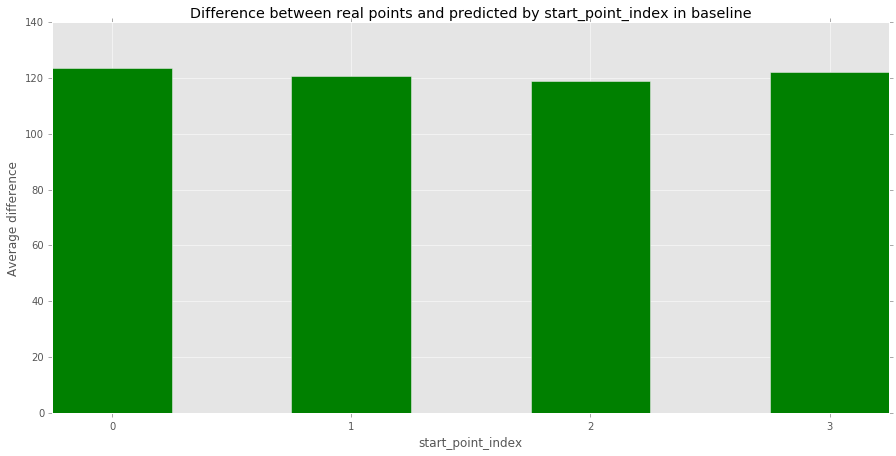

In [10]:
compare_results(function=baseline, test_results=test_results, parameter_name="start_point_index", list_of_values=range(4),
          dataframe=test_data)

In [11]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(n_estimators, train_data, train_results, test_data):
    est = RandomForestRegressor(n_estimators=n_estimators)
    est.fit(to_model(train_data), to_model(train_results))
    return from_model(est.predict(to_model(test_data)))

1/4: 2016-10-27 17:06:06
2/4: 2016-10-27 17:07:39
3/4: 2016-10-27 17:10:51
4/4: 2016-10-27 17:15:19
done! 2016-10-27 17:21:26
Results: [111.72498295408282, 107.46777167032819, 105.87541019420506, 105.45302079403953]


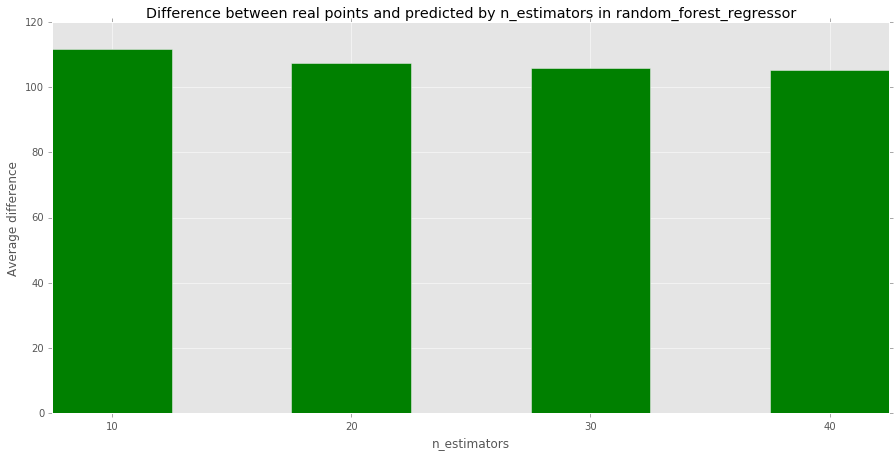

In [12]:
compare_results(function=random_forest_regressor, test_results=test_results, parameter_name="n_estimators",
                list_of_values=range(10, 50, 10), train_data=train_data, train_results=train_results,
                test_data=test_data)

In [13]:
from sklearn.neighbors import KNeighborsRegressor

# n_neighbors by defalt is 5;         to compare: range(5, 55, 5)
# weights     by defalt is 'uniform'; to compare: ['uniform', 'distance']
# algorithm   by defalt is 'auto';    to compare: ['auto', 'ball_tree', 'kd_tree', 'brute']
# note: 'brute' is causing some memory error

def kneighbors_regressor(train_data, train_results, test_data, **kwargs):
    neigh = KNeighborsRegressor(**kwargs)
    neigh.fit(to_model(train_data), to_model(train_results))
    return from_model(neigh.predict(to_model(test_data)))

1/9: 2016-10-27 17:21:32
2/9: 2016-10-27 17:21:41
3/9: 2016-10-27 17:21:49
4/9: 2016-10-27 17:21:58
5/9: 2016-10-27 17:22:07
6/9: 2016-10-27 17:22:17
7/9: 2016-10-27 17:22:27
8/9: 2016-10-27 17:22:38
9/9: 2016-10-27 17:22:50
done! 2016-10-27 17:23:02
Results: [121.04338282955339, 119.88189722959568, 121.4383890808016, 123.35636381362804, 125.54255438887743, 127.51255238025595, 129.33254750787171, 131.06234204430564, 132.73587175013878]


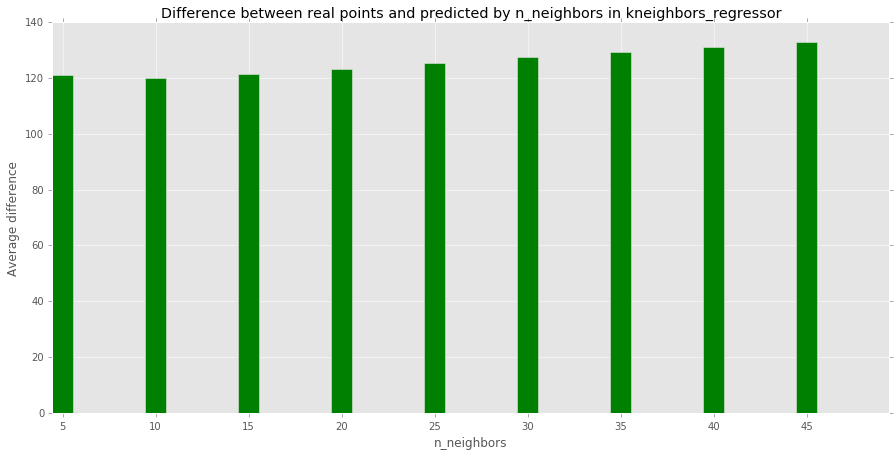

In [14]:
compare_results(function=kneighbors_regressor, test_results=test_results, parameter_name='n_neighbors',
                list_of_values=range(5, 50, 5), train_data=train_data, train_results=train_results, test_data=test_data)

In [18]:
def get_most_unpredictable_pedestrians(file, pedestrian_number):
    predicted = np.load(file)
    original = np.array(test_results)
    dist = distance_for_each_point(predicted, original)
    
    sum_dist = dist.sum(axis=0) 
    shuffled_indices = sum_dist.argsort()
    indices = shuffled_indices.copy()
    indices[::2] = np.minimum(shuffled_indices[::2], shuffled_indices[1::2])
    indices[1::2] = np.maximum(shuffled_indices[::2], shuffled_indices[1::2])
    
    for i in range(pedestrian_number):
        """
        if i == 0:
            orig_path = original[:, indices[-2:]]
            pred_path = predicted[:, indices[-2:]]
        else:
            orig_path = original[:, indices[-2*(i+1):-2*i]]
            pred_path = predicted[:, indices[-2*(i+1):-2*i]]"""
        
        orig_path = original[:, indices[2*i:2*(i+1)]]
        pred_path = predicted[:, indices[2*i:2*(i+1)]]

        pedestrian, first_frame = find_by_path(orig_path)
        
        df = download_pedestrian(pedestrian)
        prev_path = np.array(df.loc[range(first_frame - 5 * 20, first_frame, 20)])
        draw_lines(frame_number=first_frame, paths=[prev_path, orig_path, pred_path], colors=['blue', 'green', 'red'],
           image_name="{ind}_ped{num}_frame{frame}".format(ind=i+1, num=pedestrian, frame=first_frame), draw_line=False)    

In [20]:
get_most_unpredictable_pedestrians(file='src/Logs/20161027_predicted_coordinates_random_forest_regressor_n_estimators_40.npy',
                                   pedestrian_number=20)

In [99]:
neigh = KNeighborsRegressor(n_neighbors=20)
neigh.fit(to_model(train_data), to_model(train_results))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='uniform')

In [93]:
predicted = np.load('src/Logs/20161017_predicted_coordinates_kneighbors_regressor_n_neighbors_20.npy')
original = np.array(test_results)
dist = distance_for_each_point(predicted, original)

sum_dist = dist.sum(axis=0) 
shuffled_indices = sum_dist.argsort()
indices = shuffled_indices.copy()
indices[::2] = np.minimum(shuffled_indices[::2], shuffled_indices[1::2])
indices[1::2] = np.maximum(shuffled_indices[::2], shuffled_indices[1::2])

i = 17
orig_path = original[:, indices[-2*(i+1):-2*i]]
pred_path = predicted[:, indices[-2*(i+1):-2*i]]

pedestrian, first_frame = find_by_path(orig_path)

df = download_pedestrian(pedestrian)
prev_path = np.array(df.loc[range(first_frame - 5 * 20, first_frame, 20)])

In [108]:
neigh_pred = (neigh.predict(to_model(prev_path))).T

In [120]:
neigh.kneighbors(prev_path.T, return_distance=False)

array([[410876,  56146, 437800, 491610, 344256, 413674,   6232, 105854,
        495514, 172884, 107344, 264622,  60724,  13680, 429944, 175266,
        341092, 121384, 175514,   1930],
       [470595,  79859,   6149, 377683, 427234, 460977, 419590,  21993,
        419458,  30926, 380532,  20836, 358417, 510857, 270179, 290473,
        121186, 391959, 271310, 131299]], dtype=int64)